In [1]:
%matplotlib inline

In [2]:
# General setup, execute this before running any other scripts
import sys
sys.path.append('..')

from tpFlow import *

# Setup output settings for notebook
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10, 10)
import components.flowUtils
components.flowUtils.ANNOTATE_PROGRESS = False

### First vs last answer
Values in result represent mean absolute error between matrices when using first and last answer. Because performance matrix uses only 0s and 1s this value may also be interpreted as percentage of different answers (5%).

In [3]:
first = Flow('First answer', {
    'filterProblems': filterProblemsByConcept(CONCEPTS['vyjmenovana-slova-po-b']),
    'useLastAnswer': False
}, ProblemsUmime, FilterProblems, PerformanceSimilarity)
last = Flow('Basic performance projection', {
    'filterProblems': filterProblemsByConcept(CONCEPTS['vyjmenovana-slova-po-b']),
    'useLastAnswer': True
}, ProblemsUmime, FilterProblems, PerformanceSimilarity)

meanDiffPerformance = (first.getPerformanceMatrix(first.getProblems()) - last.getPerformanceMatrix(last.getProblems())).abs().mean().mean()
meanDiffSimilarity = (first.getSimilarityMatrix() - last.getSimilarityMatrix()).abs().mean().mean()

pd.DataFrame([[meanDiffPerformance], [meanDiffSimilarity]], ['performance matrix', 'similarity matrix'], ['MAE'])

,MAE
performance matrix,0.049434
similarity matrix,0.025892


### Total similarity
Used colormap represents total similarity of items; yelloy-hight, blue-low

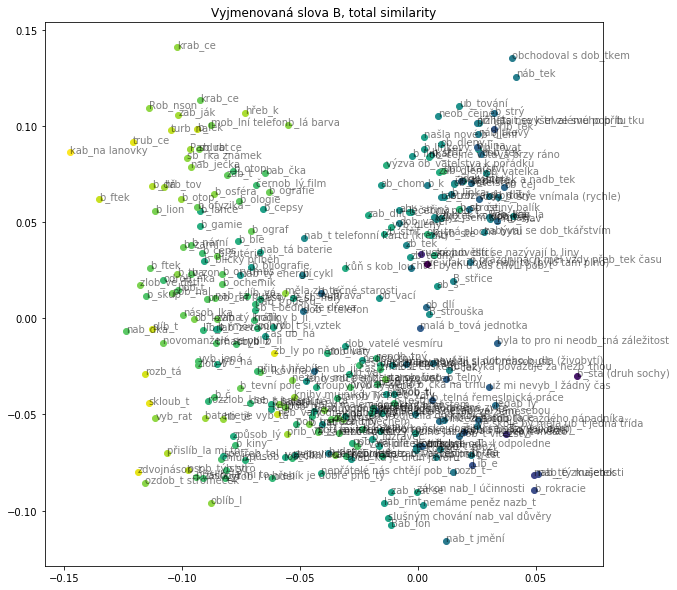

In [4]:
Flow('Vyjmenovaná slova B, total similarity', {
    'filterProblems': filterProblemsByConcept(CONCEPTS['vyjmenovana-slova-po-b'])
}, ProblemsUmime, FilterProblems, PerformanceSimilarity, TotalSimilarityColor, SimilarityMatrixPCAPlot).plot()

### Histogram of similarities
Displays same data as previous plot, but simplified to histogram. It shows distribution of similarities for both correct answers in this item-set.

/home/ienze/git/tmsei/doodle/venv/lib/python3.6/site-packages/numpy/lib/function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/ienze/git/tmsei/doodle/venv/lib/python3.6/site-packages/numpy/lib/function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


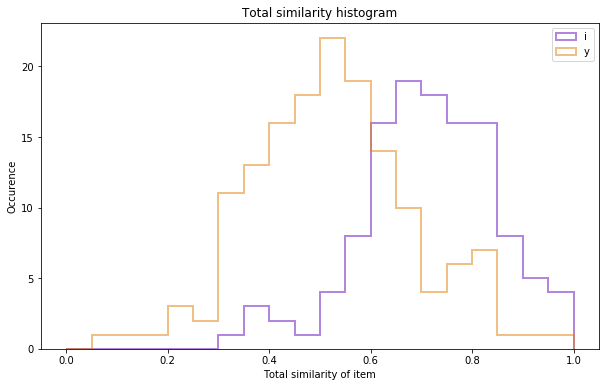

In [5]:
plt.rcParams['figure.figsize'] = (10, 6)

flow = Flow("Total similarity histogram", {
    'filterProblems': filterProblemsByConcept(CONCEPTS['vyjmenovana-slova-po-b'])
}, ProblemsUmime, FilterProblems, PerformanceSimilarity, TotalSimilarityColor)

problems = flow.getProblems()
totalSimilarity = flow.getTotalSimilarity()

plt.xlabel("Total similarity of item")
plt.ylabel("Occurence")

flow = Flow("Total similarity histogram", {
    'histogramProperty': lambda pid: totalSimilarity[pid],
    'histogramGroupBy': lambda pid: 'i' if problems[pid]['solution'] in ['i', 'í'] else 'y',
    'histogramColors': {'i': COLOR_1, 'y': COLOR_2}
}, flow, ItemHistogramPlot).plot()

plt.rcParams['figure.figsize'] = (10, 10)

### Simulated default asnwer
Simulation of users preffering one answer over another. They have 20% greater chance to answer items with first answer correctly and 20% lower chance to succed on items with second answer.

We also show corresponding performance and similarity matrices.

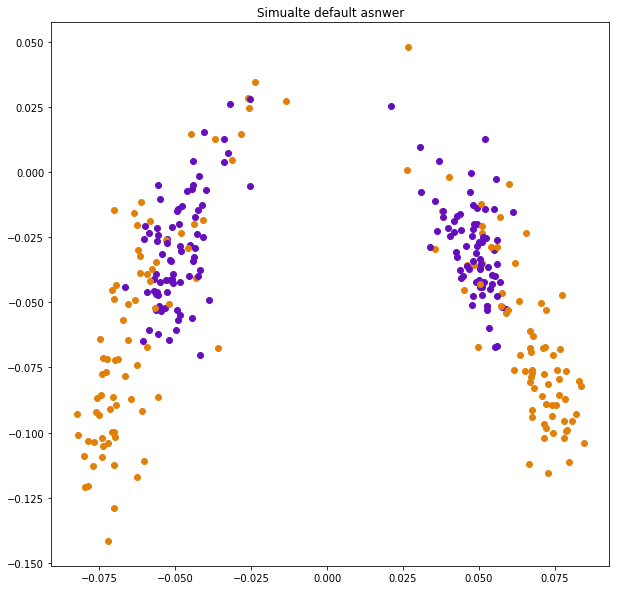

In [6]:
simulatedDefaultAnswer = Flow("Simualte default asnwer", {
    'questionCount': 300,
    'questionDifficulty': [0.0],
    'questionSkill': [0.0, 0.0],
    'questionDifficultyShift': [-0.2, 0.2],
    'userCount': 3000,
    'lambdaColor': lambda problem: [COLOR_1, COLOR_2][problem['difficultyShiftGroup']],
    'annotate': 0.0
}, ProblemsSimulatedDefaultAnswer, PerformanceSimilarity, LambdaProblemColor, SimilarityMatrixPCAPlot)
simulatedDefaultAnswer.plot()

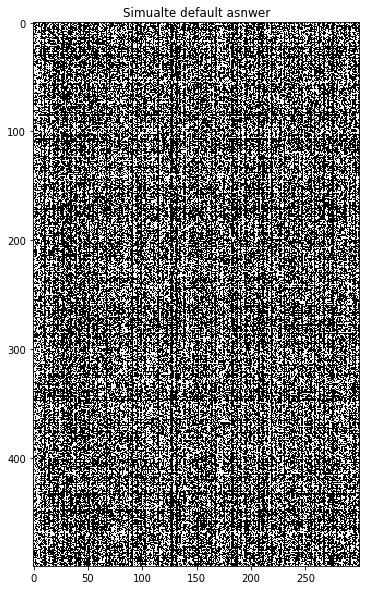

In [7]:
PerformanceMatrixPlot(simulatedDefaultAnswer).plot()

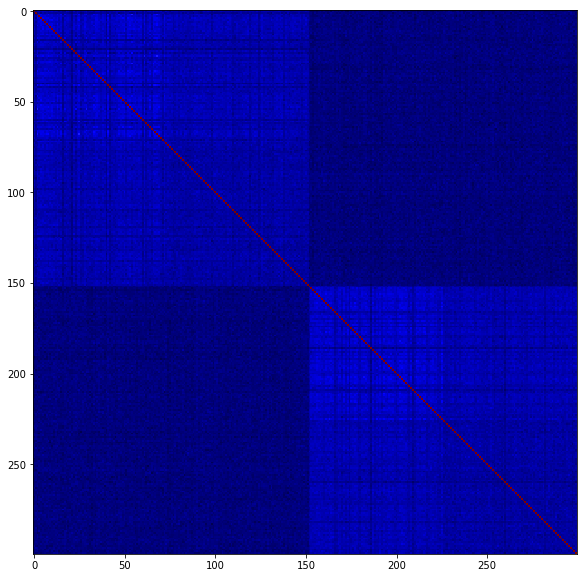

In [8]:
Flow("", {
    'orderProblems': lambda problem: problem['skillGroup'] * 300 - problem['difficultyShiftGroup']
}, simulatedDefaultAnswer, SimilarityMatrixPlot).plot()

### Normalize answer reglarity
This example shows code for filtering out users with large difference in performance on possible answers.

Median user answer differnece 0.0667892156862745
Removed 3540 users


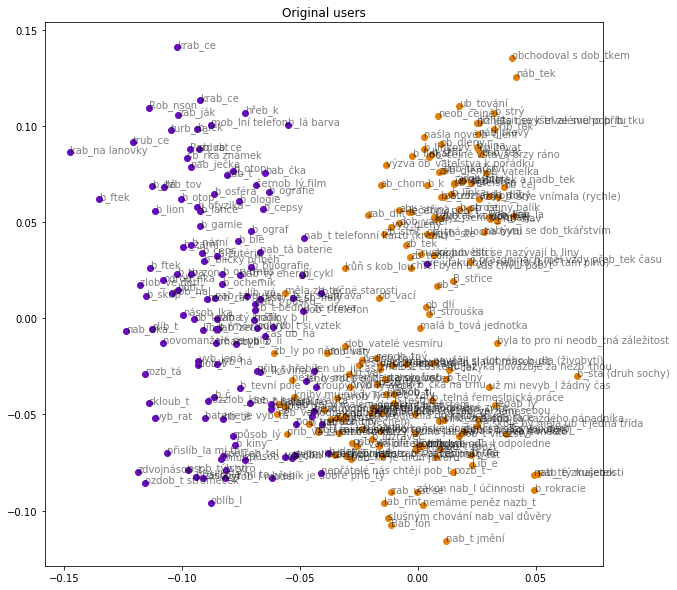

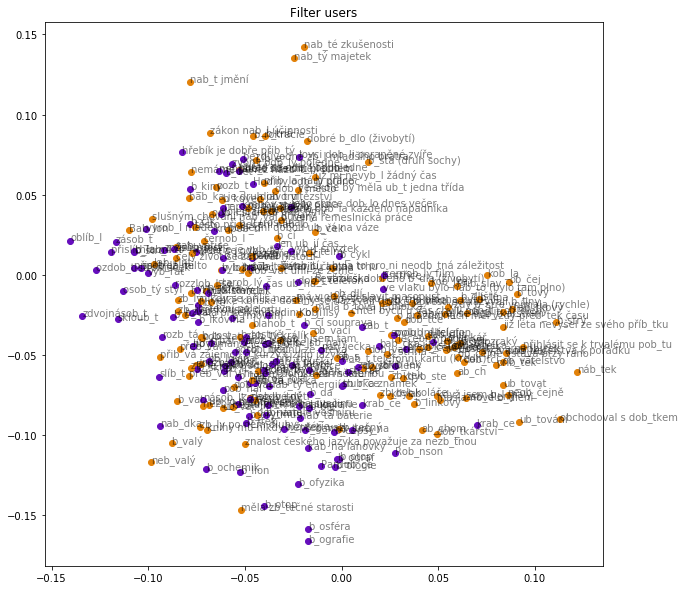

In [9]:
filterUsersFlow = Flow('Cestina data', {
    'filterProblems': filterProblemsByConcept(CONCEPTS["vyjmenovana-slova-po-b"])
}, ProblemsUmime, FilterProblems)

problems = filterUsersFlow.getProblems()
perfMatrix = filterUsersFlow.getPerformanceMatrix(problems).to_dense() # runs much faster in dense form

userAnswerPerformanceMatrix = perfMatrix.groupby(lambda pid: 'i' if problems[pid]['solution'] in ['i', 'í'] else 'y', axis=1).mean()
userAnswerDifference = userAnswerPerformanceMatrix.apply(lambda row: abs(row['i'] - row['y']), axis=1)

print("Median user answer differnece", userAnswerDifference.median())
filterUsers = userAnswerDifference < 0.2

print("Removed", filterUsers.value_counts()[False], "users")

Flow('Original users', {
    'lambdaColor': lambda problem: COLOR_1 if problem['solution'] in ['i', 'í'] else COLOR_2,
}, filterUsersFlow, FilterProblems, PerformanceSimilarity, LambdaProblemColor, SimilarityMatrixPCAPlot).plot()

filteredFlow = Flow('Filter users', {
    'lambdaColor': lambda problem: COLOR_1 if problem['solution'] in ['i', 'í'] else COLOR_2,
    'filterUsers': lambda user: filterUsers[user]
}, filterUsersFlow, FilterProblems, PerformanceSimilarity, LambdaProblemColor, SimilarityMatrixPCAPlot)
filteredFlow.plot()

### Normalize component

Normalization is also implemented as component to use easily in context of Umime cesky. Parameter `normalizeAnswersTreshold` is difference over which are users filtered out.

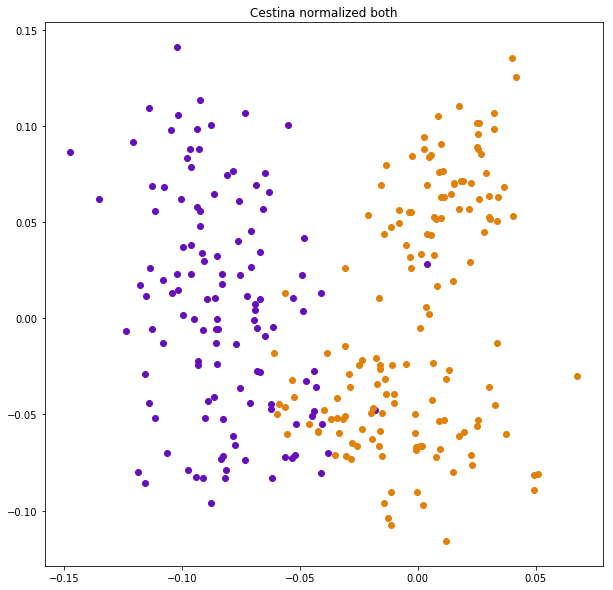

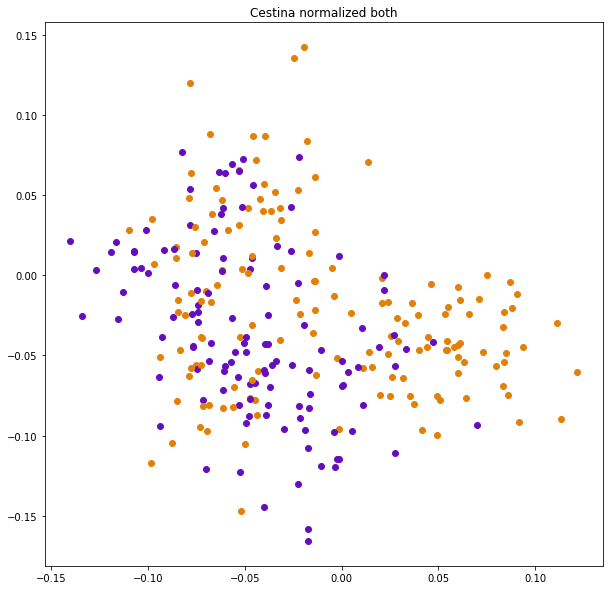

In [10]:
item_set = CONCEPTS["vyjmenovana-slova-po-b"]
cestinaNormalized = Flow('Cestina normalized both', {
    'filterProblems': filterProblemsByConcept(item_set),
    'lambdaColor': lambda problem: COLOR_1 if problem['solution'] in ['i', 'í'] else COLOR_2,
    'normalizeAnswers': False,
    'annotate': 0.0,
}, ProblemsUmime, FilterProblems, PerformanceMatrixNormalization, PerformanceSimilarity, LambdaProblemColor, SimilarityMatrixPCAPlot)
cestinaNormalized.plot()

cestinaNormalized = Flow('Cestina normalized both', {
    'filterProblems': filterProblemsByConcept(item_set),
    'lambdaColor': lambda problem: COLOR_1 if problem['solution'] in ['i', 'í'] else COLOR_2,
    'normalizeAnswers': True,
    'normalizeAnswersTreshold': 0.2,
    'annotate': 0.0,
}, ProblemsUmime, FilterProblems, PerformanceMatrixNormalization, PerformanceSimilarity, LambdaProblemColor, SimilarityMatrixPCAPlot)
cestinaNormalized.plot()

### Histogram of user answer difference

Histograms shows distribution of user answer difference. Second histogram is normalized by amount of answers from user - so users sho answered only few questins dont show as much. This hides exteme cases like difference 1.0.

In [11]:
basicDataflow = Flow('Basic data', {
    'filterProblems': filterProblemsByConcept(CONCEPTS['vyjmenovana-slova-po-b']),
}, ProblemsUmime, FilterProblems, PerformanceSimilarity)

/home/ienze/git/tmsei/doodle/venv/lib/python3.6/site-packages/numpy/lib/function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/ienze/git/tmsei/doodle/venv/lib/python3.6/site-packages/numpy/lib/function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


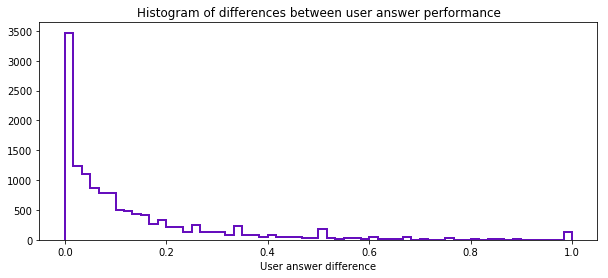

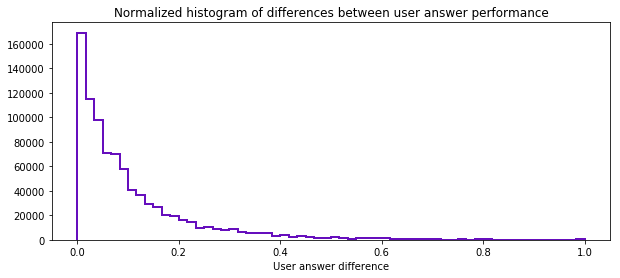

In [12]:
plt.rcParams['figure.figsize'] = (10, 4)

problems = basicDataflow.getProblems()
perfMatrix = basicDataflow.getPerformanceMatrix(problems).to_dense()

userAnswerPerformanceMatrix = perfMatrix.groupby(lambda pid: 'i' if problems[pid]['solution'] in ['i', 'í'] else 'y', axis=1).mean()
userAnswerDifference = userAnswerPerformanceMatrix.apply(lambda row: abs(row['i'] - row['y']), axis=1)
userAnswerCount = perfMatrix.notnull().sum(axis=1)

plt.hist(userAnswerDifference, 60, (0.0, 1.0), histtype = 'step', linewidth=2.0, color=COLOR_1)
plt.title("Histogram of differences between user answer performance")
plt.xlabel("User answer difference")
plt.show()

plt.hist(userAnswerDifference, 60, (0.0, 1.0), weights=userAnswerCount, histtype = 'step', linewidth=2.0, color=COLOR_1)
plt.title("Normalized histogram of differences between user answer performance")
plt.xlabel("User answer difference")
plt.show()

plt.rcParams['figure.figsize'] = (10, 10)

### Total similarity boxplot by answer

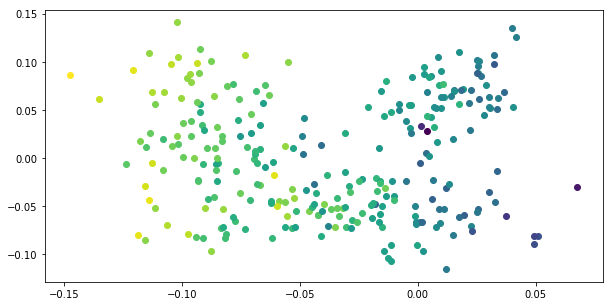

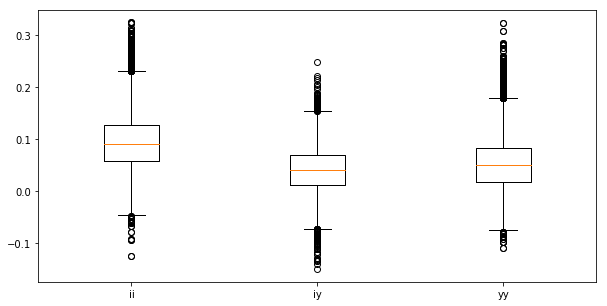

In [13]:
plt.rcParams['figure.figsize'] = (10, 5)

basicDataflow = Flow('Basic data', {
    'filterProblems': filterProblemsByConcept(CONCEPTS['vyjmenovana-slova-po-b']),
}, ProblemsUmime, FilterProblems, PerformanceSimilarity)

Flow("", {'annotate': 0.0}, basicDataflow, TotalSimilarityColor, SimilarityMatrixPCAPlot).plot()

fig, ax = plt.subplots(1)

boxes = [[] for i in range(4)]
problems = basicDataflow.getProblems()
simMatrix = basicDataflow.getSimilarityMatrix()

for col in list(simMatrix):
    i1 = 0 if problems[col]['solution'] in ['i', 'í'] else 2
    for row in list(simMatrix):
        i2 = 0 if problems[row]['solution'] in ['i', 'í'] else 1
        if col != row:
            boxes[i1 + i2].append(simMatrix.loc[col, row])

plt.boxplot([boxes[0], boxes[1], boxes[3]])
ax.set_xticklabels(['ii', 'iy', 'yy'])
plt.show()

plt.rcParams['figure.figsize'] = (10, 10)

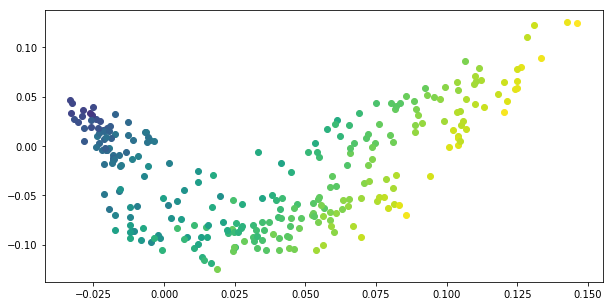

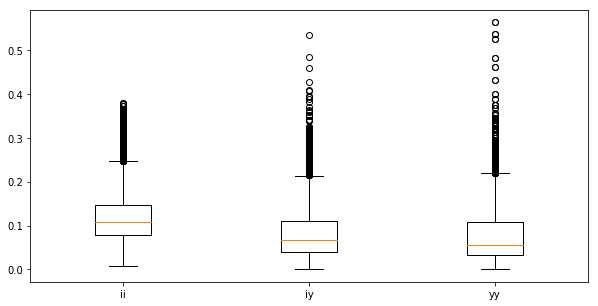

In [14]:
plt.rcParams['figure.figsize'] = (10, 5)

jaccardDataflow = Flow('Jaccard data', {
    'filterProblems': filterProblemsByConcept(CONCEPTS['vyjmenovana-slova-po-b']),
    'similarityMetric': 'jaccard'
}, ProblemsUmime, FilterProblems, BooleanPerformanceSimilarity)

Flow("", {'annotate': 0.0}, jaccardDataflow, TotalSimilarityColor, SimilarityMatrixPCAPlot).plot()

fig, ax = plt.subplots(1)

boxes = [[] for i in range(4)]
problems = jaccardDataflow.getProblems()
simMatrix = jaccardDataflow.getSimilarityMatrix()

for col in list(simMatrix):
    i1 = 0 if problems[col]['solution'] in ['i', 'í'] else 2
    for row in list(simMatrix):
        i2 = 0 if problems[row]['solution'] in ['i', 'í'] else 1
        if col != row:
            boxes[i1 + i2].append(simMatrix.loc[col, row])

plt.boxplot([boxes[0], boxes[1], boxes[3]])
ax.set_xticklabels(['ii', 'iy', 'yy'])
plt.show()

plt.rcParams['figure.figsize'] = (10, 10)

### Comparasion of answers in defferent item-sets

Following two plts looks similar and they both show some correlation. Each item-set is showed as line where its ends are possible answers. Their position shows observed property and only item-sets with two possible answers are shown.

First plot shows correlation of answer similarity and amount of items it has

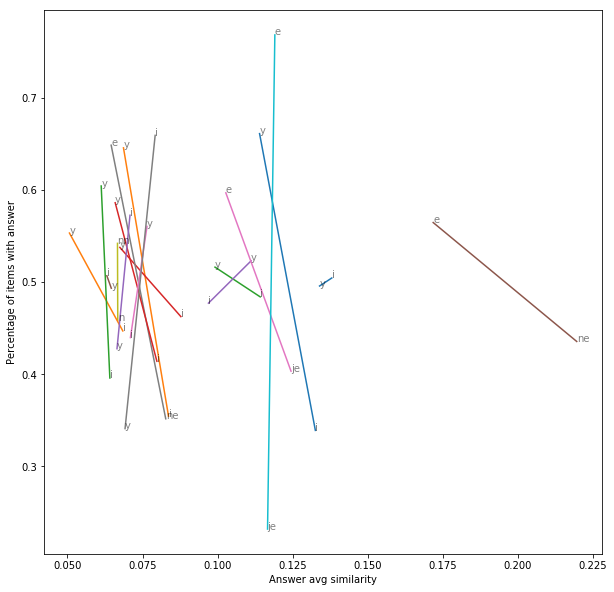

In [15]:
for conceptTitle in sorted(CONCEPTS):
    conceptPss = CONCEPTS[conceptTitle]
    conceptFlow = Flow(conceptTitle, {
        'maxProblems': False,
        'filterProblems': lambda problem: [x for x in conceptPss if x in problem['pss']],
    }, ProblemsUmime, FilterProblems, PerformanceSimilarity)

    if conceptTitle.startswith("delka-"):
        transformSolution = lambda a: a
    else:
        transformSolution = unidecode

    problems = conceptFlow.getProblems()
    answers = set([transformSolution(problem['solution']) for pid, problem in problems.items()])
    answers = sorted(list(answers))

    if len(answers) != 2:
        continue

    totalSims = [[] for x in answers]
    simMatrix = conceptFlow.getSimilarityMatrix()
    for pid in simMatrix:
        problemAnswerIndex = answers.index(transformSolution(problems[pid]['solution']))
        for x in simMatrix[pid]:
            totalSims[problemAnswerIndex].append(x)

    totalSimsCount = sum([len(sims) for sims in totalSims])

    avgSimilarity = [np.mean(sims) for sims in totalSims]
    nSimilarities = [len(sims) / totalSimsCount for sims in totalSims]
    # c = (random(), random(), random())

    plt.plot(avgSimilarity, nSimilarities, "-")

    plt.text(avgSimilarity[0], nSimilarities[0], answers[0], alpha=0.5)
    plt.text(avgSimilarity[1], nSimilarities[1], answers[1], alpha=0.5)

plt.xlabel("Answer avg similarity")
plt.ylabel("Percentage of items with answer")
plt.show()

Second plot shows correlation of item similarity and amount of answers from users for each item. Notice values on y-axis - almost all answers have usage near 50% even when it is not true for amount of correct answers (previous plot).

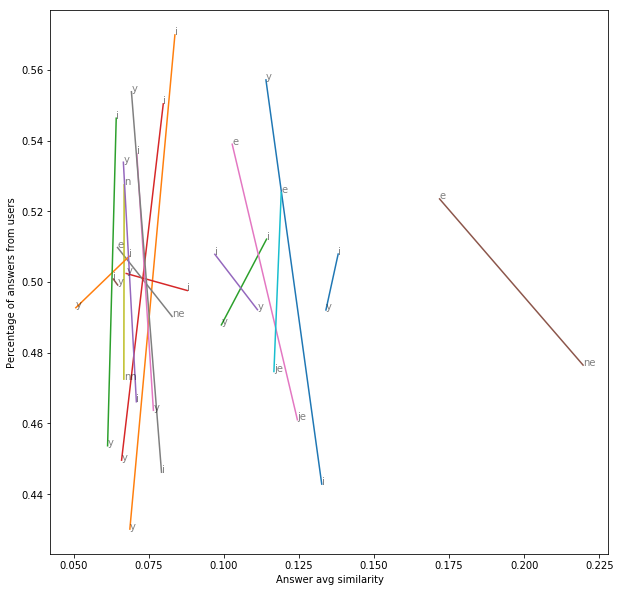

In [16]:
for conceptTitle in sorted(CONCEPTS):
    conceptPss = CONCEPTS[conceptTitle]
    conceptFlow = Flow(conceptTitle, {
        'maxProblems': False,
        'filterProblems': lambda problem: [x for x in conceptPss if x in problem['pss']],
    }, ProblemsUmime, FilterProblems, PerformanceSimilarity)

    if conceptTitle.startswith("delka-"):
        transformSolution = lambda a: a
    else:
        transformSolution = unidecode

    problems = conceptFlow.getProblems()
    answers = set([transformSolution(problem['solution']) for pid, problem in problems.items()])
    answers = sorted(list(answers))

    if len(answers) != 2:
        continue

    totalSims = [[] for x in answers]
    simMatrix = conceptFlow.getSimilarityMatrix()
    for pid in simMatrix:
        problemAnswerIndex = answers.index(transformSolution(problems[pid]['solution']))
        for x in simMatrix[pid]:
            totalSims[problemAnswerIndex].append(x)

    totalAnswers = [0 for x in answers]
    perfMatrix = conceptFlow.getPerformanceMatrix(problems)
    for pid in perfMatrix:
        problemAnswerIndex = answers.index(transformSolution(problems[pid]['solution']))
        for c in perfMatrix[pid]:
            answered = problemAnswerIndex if c == 1.0 else (problemAnswerIndex + 1) % 2 #HACK this works only for questions with two asnwers
            totalAnswers[answered] += 1

    totalAnswersCount = sum(totalAnswers)

    avgSimilarity = [np.mean(sims) for sims in totalSims]
    totalAnswersNormed = [ans / totalAnswersCount for ans in totalAnswers]

    plt.plot(avgSimilarity, totalAnswersNormed, "-")

    plt.text(avgSimilarity[0], totalAnswersNormed[0], answers[0], alpha=0.5)
    plt.text(avgSimilarity[1], totalAnswersNormed[1], answers[1], alpha=0.5)
#     plt.text(avgSimilarity[0], totalAnswersNormed[0] + 0.005 * (1.0 if totalAnswersNormed[0] > 0.5 else -1.0), conceptTitle, alpha=0.5)

plt.xlabel("Answer avg similarity")
plt.ylabel("Percentage of answers from users")
plt.show()

### Distribution of user answer difference on simulated data

To chose value for filtering out users for one of the previous experiments we ploted hisotrgams of diffeent simulated properties. First plot shows system where all users prefer some answer, and second plot system with no prefference at all.

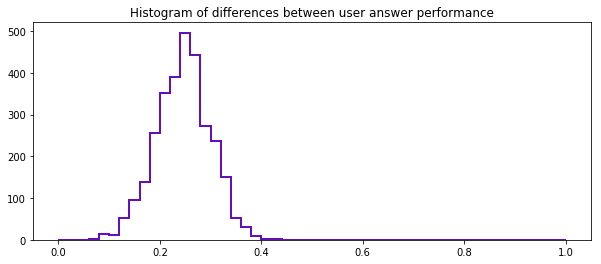

In [17]:
plt.rcParams['figure.figsize'] = (10, 4)

simulatedDefaultAnswer = Flow("Simualte default asnwer", {
    'questionCount': 300,
    'questionDifficulty': [0.0],
    'questionSkill': [0.0, 0.0],
    'questionDifficultyShift': [-0.2, 0.2],
    'userCount': 3000,
    'lambdaColor': lambda problem: ['red', 'blue'][problem['difficultyShiftGroup']],
    'annotate': 0.0
}, ProblemsSimulatedDefaultAnswer, PerformanceSimilarity, LambdaProblemColor, SimilarityMatrixPCAPlot)

problems = simulatedDefaultAnswer.getProblems()
perfMatrix = simulatedDefaultAnswer.getPerformanceMatrix(problems).to_dense()

userAnswerPerformanceMatrix = perfMatrix.groupby(lambda pid: 'i' if problems[pid]['difficultyShiftGroup'] in [0] else 'y', axis=1).mean()
userAnswerDifference = userAnswerPerformanceMatrix.apply(lambda row: abs(row['i'] - row['y']), axis=1)

plt.hist(userAnswerDifference, 50, (0.0, 1.0), histtype = 'step', linewidth=2.0, color=COLOR_1)
plt.title("Histogram of differences between user answer performance")
plt.show()

plt.rcParams['figure.figsize'] = (10, 10)

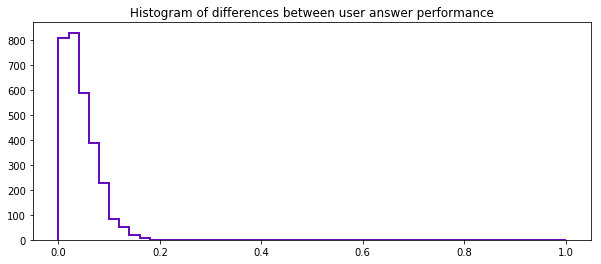

In [18]:
plt.rcParams['figure.figsize'] = (10, 4)

simulatedDefaultAnswer = Flow("Simualte default asnwer", {
    'questionCount': 300,
    'questionDifficulty': [8.0],
    'questionSkill': [0.0, 0.0],
    'questionDifficultyShift': [0.0, 0.0],
    'userCount': 3000,
    'lambdaColor': lambda problem: ['red', 'blue'][problem['difficultyShiftGroup']],
    'annotate': 0.0
}, ProblemsSimulatedDefaultAnswer, PerformanceSimilarity, LambdaProblemColor, SimilarityMatrixPCAPlot)

problems = simulatedDefaultAnswer.getProblems()
perfMatrix = simulatedDefaultAnswer.getPerformanceMatrix(problems).to_dense()

userAnswerPerformanceMatrix = perfMatrix.groupby(lambda pid: 'i' if problems[pid]['difficultyShiftGroup'] in [0] else 'y', axis=1).mean()
userAnswerDifference = userAnswerPerformanceMatrix.apply(lambda row: abs(row['i'] - row['y']), axis=1)

plt.hist(userAnswerDifference, 50, (0.0, 1.0), histtype = 'step', linewidth=2.0, color=COLOR_1)
plt.title("Histogram of differences between user answer performance")
plt.show()

userAnswerPerformanceMatrix.mean().mean()

plt.rcParams['figure.figsize'] = (10, 10)

### Number of simulated users affecting shape of projection

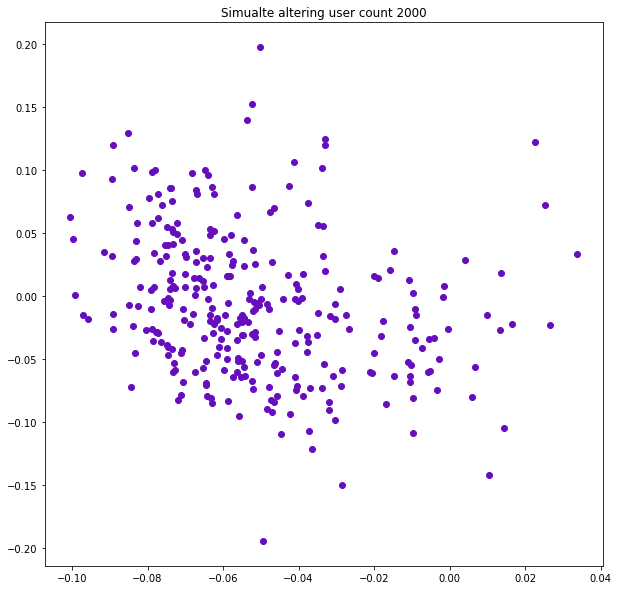

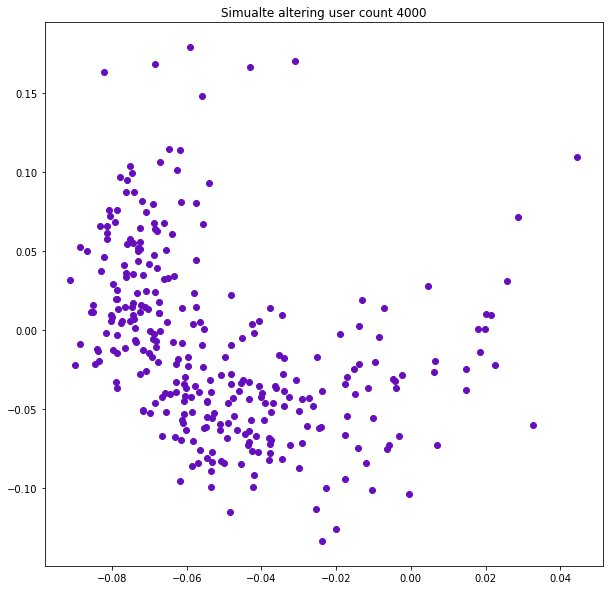

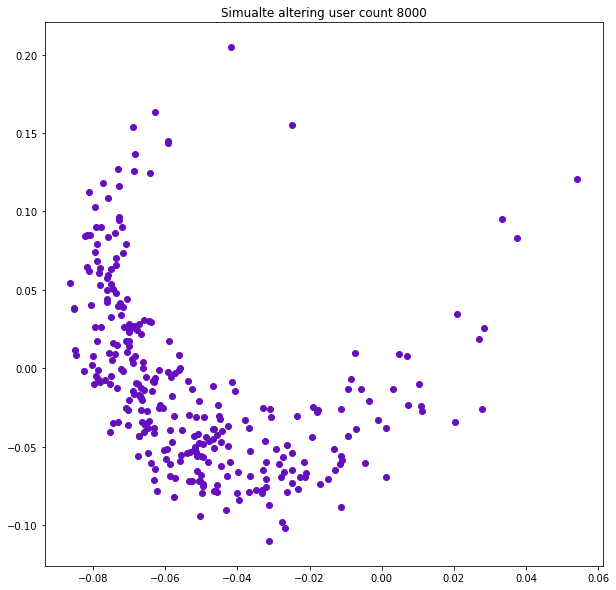

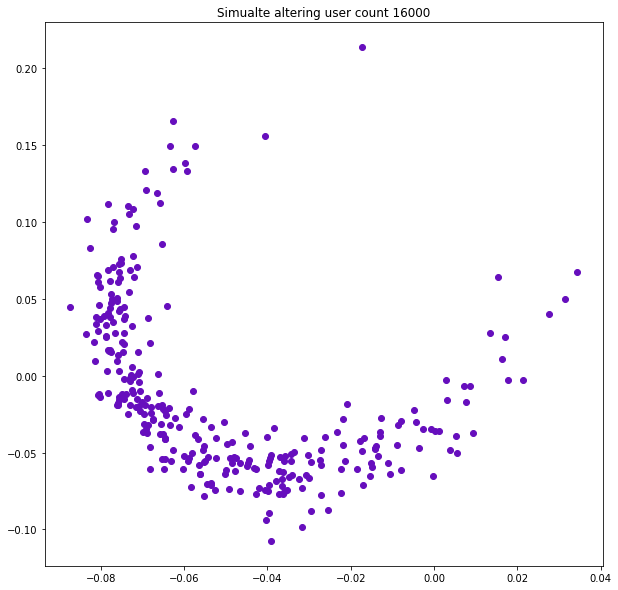

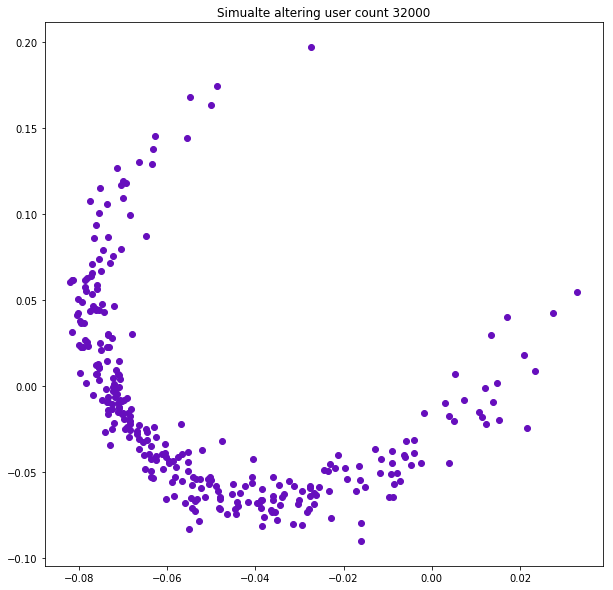

In [20]:
for uc in [2000, 4000, 8000, 16000, 32000]:
    Flow("Simualte altering user count "+str(uc), {
        'questionCount': 300,
        'questionDifficulty': [0.0],
        'questionSkill': [0.0],
        'questionDifficultyShift': [0.0],
        'userCount': uc,
        'lambdaColor': lambda problem: COLOR_1,
        'annotate': 0.0
    }, ProblemsSimulatedDefaultAnswer, PerformanceSimilarity, LambdaProblemColor, SimilarityMatrixPCAPlot).plot()